In [2]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas
import json

def leggi_configurazione(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        config = json.load(f)
    return config

def plotpy(config): #accetta in input un dizionario
    object = config.get("object","hist")
    drawErrors = config.get("drawErrors", False)
    logy = config.get("logy", False)
    xlabel = config.get("xlabel", "")
    ylabel = config.get("ylabel", "")
    title = config.get("title", "")
    location = config.get("location", "best")
    xlow = config.get("xlow", 0)
    xhigh = config.get("xhigh", 10)
    ylow = config.get("ylow", 1e-4)
    yhigh = config.get("yhigh", 10)
    xticks_interval = config.get("xticks_interval", 1)
    rotation = config.get("rotation", 0)
    savepath = config.get("savepath", "grafico.png")
    fmt = config.get("format", "png")
    rebin = config.get("rebin", False)
    rebfactor = config.get("rebfactor", 1)
    
    bmaxs=[]
    if object == "hist":
        for hist in config["istogrammi"]:
            file_path, hist_name = hist["path"].split(":")
            colore = hist.get("colore", "blue")
            llabel = hist.get("label", "")
            aaplha = hist.get("alpha",1)
            ls = hist.get("ls","-")

            f = ROOT.TFile.Open(file_path)
            th1d = f.Get(hist_name)

            

            if rebin : th1d.Rebin(rebfactor)
            n_bins = th1d.GetNbinsX()

            #trovo l'istogramma più alto
            ymax=th1d.GetBinContent(1)
            for bin in range(1,th1d.GetNbinsX()+1):
                if th1d.GetBinContent(bin) > ymax : ymax = th1d.GetBinContent(bin)
            bmaxs.append(ymax)
            #print(ymax)

            x_edges = [th1d.GetBinLowEdge(i+1) for i in range(n_bins)]
            x_edges.append(th1d.GetBinLowEdge(n_bins) + th1d.GetBinWidth(n_bins))
            bin_contents = [th1d.GetBinContent(i+1) for i in range(n_bins)]
            bin_errors = [th1d.GetBinError(i+1) for i in range(n_bins)]
            bin_centers =[th1d.GetBinCenter(i+1) for i in range(n_bins)]
            x_bin_errors=[th1d.GetBinWidth(i+1)/2 for i in range(n_bins)]

            bin_errors_new = bin_errors
            bin_contents_new = bin_contents
            yerr_low  = np.minimum(np.array(bin_errors_new), 0.999 * np.array(bin_contents_new))  
            yerr_high = np.array(bin_errors_new)      

            # Creazione step per linee orizzontali
            x_step = np.repeat(x_edges, 2)[1:-1]
            y_step = np.repeat(bin_contents, 2)

            # Aggiunta linee verticali agli estremi
            x_step = np.insert(x_step, 0, x_edges[0])
            y_step = np.insert(y_step, 0, 0)  # parte dal basso
            x_step = np.append(x_step, x_edges[-1])
            y_step = np.append(y_step, 0)     # torna a 0 alla fine

            plt.step(x_step, y_step, where='mid', linewidth=2, color=colore, label=llabel, alpha=aaplha, linestyle=ls)

            if drawErrors:
                plt.errorbar(bin_centers,bin_contents,yerr=[yerr_low, yerr_high], fmt='o', color=colore, markersize=1, alpha=0.6, capsize=2)

    if object == "graph":
        for g in config["grafici"]:
            file_path, g_name = g["path"].split(":")
            colore = g.get("colore", "")
            llabel = g.get("label", "")
            aalpha = g.get("alpha",1)

            f = ROOT.TFile.Open(file_path)
            graph = f.Get(g_name)
            n_points = graph.GetN()
            x = np.array([graph.GetPointX(i) for i in range(n_points)], dtype=float)
            y = np.array([graph.GetPointY(i) for i in range(n_points)], dtype=float)

            if drawErrors:
                ex = np.array([graph.GetErrorX(i) for i in range(n_points)], dtype=float)
                ey = np.array([graph.GetErrorY(i) for i in range(n_points)], dtype=float)
                plt.errorbar(x,y,yerr=ey, fmt='o', color=colore, markersize=2, alpha=aalpha, capsize=2, label=llabel)
            else:
                plt.plot(x,y,color=colore, alpha=aalpha, label=llabel)


    if logy: plt.yscale('log')

    maxy=0
    for max in bmaxs:
        if max>maxy : maxy=max

    #print("ymax is",maxy)

    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)

    colore_titolo = (34,73,120)
    colore_titolo_mpl = tuple(c / 255 for c in colore_titolo)
    plt.title(title, fontsize=18, color=colore_titolo_mpl)

    leg = plt.legend(loc=location, fontsize=12)
    leg.get_frame().set_facecolor('white')  # sfondo bianco della legenda
    leg.get_frame().set_alpha(1.0)          # opaco
    plt.setp(leg.get_title(), fontweight='bold')

    plt.setp(plt.gca().get_legend().get_title(), fontweight='bold')
    plt.xticks(np.arange(xlow,xhigh,xticks_interval), fontsize=14, rotation=rotation)
    plt.xlim(xlow,xhigh)
    plt.ylim(ylow,maxy*1.1)
    plt.yticks(fontsize=14)

    plt.savefig(savepath, format=fmt, dpi=600, bbox_inches='tight')
    plt.close()
    

Welcome to JupyROOT 6.26/07


In [11]:
config = leggi_configurazione("plot_config.json")
plotpy(config)

In [42]:

config = leggi_configurazione("plot_config.json")

pars=["muon", "proton", "pion"]
colors=["cornflowerblue", "orange", "green"]
i=0
for rr in [x / 2 for x in range(3, 51)]:
        i=i+1
        istogrammi = []
        for par in range(3):
            istogrammi.append({
                "path": f"dEdxdistro.root:{pars[par]}/{rr:.1f}/dEdx_ind2_rr_{rr:.1f}",
                "label": pars[par],
                "colore": colors[par],  # puoi mappare i colori
                "alpha": 1,
                "ls": "solid"
            })

        config["object"] = "hist"
        config["istogrammi"] = istogrammi
        config['xlabel']='dEdx [MeV/cm]'
        config['ylabel']='counts (area normalized)'
        config['location']='upper right'
        config['xhigh']=30
        config["title"] = f"dEdx INDUCTION 2 plane, $rr \\in [{rr-0.5:.1f},{rr:.1f}]$ cm"
        #config["savepath"] = f"plotdEdx/dEdx_rr_{rr:.1f}.pdf"
        config['savepath'] = f"frames_ind2/frame_{i}.png"

        plotpy(config)

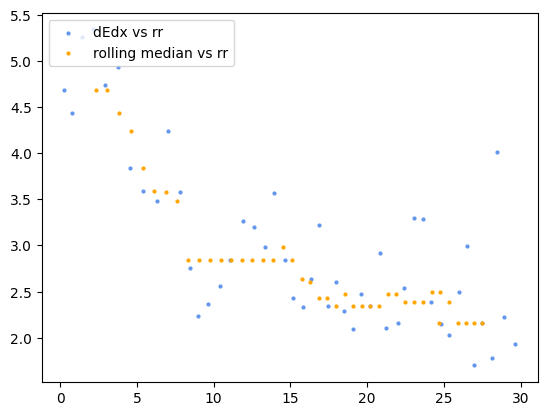

In [28]:
import matplotlib.pyplot as plt
rr = []
dedx = []
rr_rm = []
rm = []
buffer=[]
this_track = -1
selected_track = 27

with open('/storage/gpfs_data/icarus/local/users/sommaggio/simul_z/event_display/dumpRollingMedian.txt') as f:
    for line in f:
        line = line.strip()
        if line.split()[0] =='track' : 
            this_track = this_track + 1
            continue
        if this_track == selected_track:
            buffer.append([float(x) for x in line.split()])
            if len(buffer)==4: 
                rr , dedx, rr_rm, rm = buffer
                break

plt.scatter(rr,dedx,label='dEdx vs rr',s=4,color='cornflowerblue')
plt.scatter(rr_rm,rm,label='rolling median vs rr', s=4, color='orange')
plt.legend(loc='upper left')
        
